# Bycicle Counter Prediction

In [1]:
# imports
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor 

## 1. Data gathering

In [ ]:
# download extended bycicle counter datasets (!wget if not on UNIX)
!curl 'https://data.stad.gent/api/explore/v2.1/catalog/datasets/fietstelpaal-coupure-links-2023-gent/exports/csv?lang=en&timezone=Europe%2FBrussels&use_labels=true&delimiter=%3B' -o 'data/fiets_2023.csv'
!curl 'https://data.stad.gent/api/explore/v2.1/catalog/datasets/fietstelpaal-coupure-links-2022-gent/exports/csv?lang=en&timezone=Europe%2FBrussels&use_labels=true&delimiter=%3B' -o 'data/fiets_2022.csv'
!curl 'https://data.stad.gent/api/explore/v2.1/catalog/datasets/fietstelpaal-coupure-links-2021-gent/exports/csv?lang=en&timezone=Europe%2FBrussels&use_labels=true&delimiter=%3B' -o 'data/fiets_2021.csv'

# Download weather data
!curl 'https://archive-api.open-meteo.com/v1/archive?latitude=51.100006&longitude=3.699997&start_date=2021-03-01&end_date=2023-07-31&hourly=temperature_2m,precipitation,rain,snowfall,snow_depth,cloudcover,windspeed_10m,windgusts_10m&format=csv' -o 'data/weather_data_full.csv'

## 2. Preprocessing

In [2]:
# Load in data
fiets_2023 = pd.read_csv('./data/fiets_2023.csv',delimiter=';')
fiets_2022 = pd.read_csv('./data/fiets_2022.csv',delimiter=';')
fiets_2021 = pd.read_csv('./data/fiets_2021.csv',delimiter=';')

weather_data = pd.read_csv('./data/weather_data_full.csv',skiprows=3)
test_data = pd.read_csv('./data/test_data.csv')

# concatenate the training data
train_data = pd.concat([fiets_2021, fiets_2022, fiets_2023], ignore_index=True)

In [3]:
# Convert time columns to pandas datetime format
## test data
test_data['datetime'] = pd.to_datetime(test_data['Date_hour'])

## train data
train_data['datetime'] = pd.to_datetime(train_data['Datum']+ ' ' + train_data['Uur5Minuten'])

## weather data
weather_data['datetime'] = pd.to_datetime(weather_data['time'])

In [4]:
# drop irrelevant time columns
train_data = train_data[['datetime','Totaal']]
weather_data = weather_data.drop('time',axis =1)
test_data = test_data.drop('Date_hour',axis=1)

# Remove datapoints later than 30th of june 2023
train_data = train_data[train_data['datetime'] <= '2023-06-30 23:00']

# Group by hour
train_data = train_data.groupby(train_data['datetime'].dt.strftime('%Y-%m-%d %H:00'))['Totaal'].sum()

# reset index
train_data = train_data.reset_index()

# reset "datetime" column to pandas datetime format as this changes to "object" type during execution of the "groupby" function.
train_data['datetime'] = pd.to_datetime(train_data['datetime'])

In [5]:
# Merge weather data with training data and test data, based on timepoints
train_data = pd.merge(train_data, weather_data, on='datetime', how='inner')
test_data = pd.merge(test_data, weather_data, on='datetime', how='inner')

# index
test_data.set_index('Id')

,datetime,temperature_2m (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h)
Id,,,,,,,,,
0,2023-07-01 00:00:00,18.0,0.0,0.0,0.0,0.0,100,18.8,37.1
1,2023-07-01 01:00:00,17.7,0.0,0.0,0.0,0.0,100,20.4,39.6
2,2023-07-01 02:00:00,17.4,0.0,0.0,0.0,0.0,100,21.9,41.0
3,2023-07-01 03:00:00,17.2,0.0,0.0,0.0,0.0,100,21.7,41.8
4,2023-07-01 04:00:00,17.2,0.0,0.0,0.0,0.0,100,20.9,41.8
...,...,...,...,...,...,...,...,...,...
739,2023-07-31 19:00:00,17.6,0.4,0.4,0.0,0.0,100,17.5,30.2
740,2023-07-31 20:00:00,17.3,0.1,0.1,0.0,0.0,98,17.0,31.7
741,2023-07-31 21:00:00,17.0,0.1,0.1,0.0,0.0,82,17.1,32.8


## 3. Data exploration

- Basic info
- Correlation
- PCA is unnessecary as we aren't dealing with a large number of variables

### 3.1 Correlation analysis

Totaal                  1.000000
temperature_2m (°C)     0.222536
windgusts_10m (km/h)    0.075790
snow_depth (m)          0.015638
windspeed_10m (km/h)    0.012239
cloudcover (%)          0.011943
precipitation (mm)      0.008858
rain (mm)               0.008830
snowfall (cm)           0.000880
Name: Totaal, dtype: float64


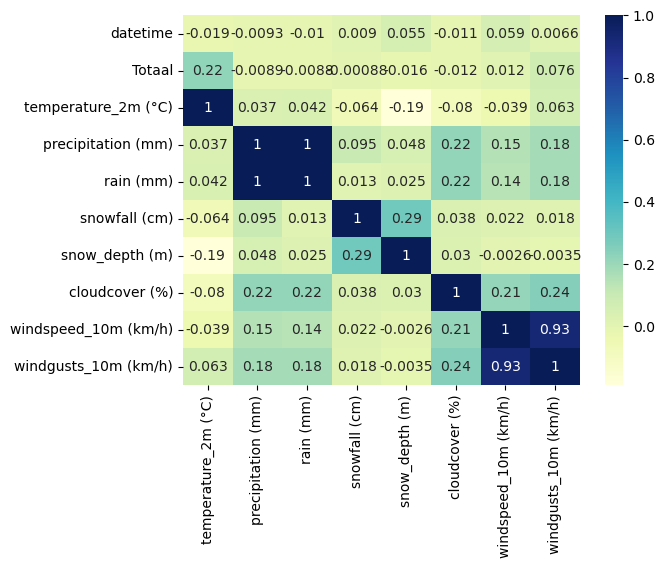

In [6]:
correlation = train_data.corr()['Totaal'].drop('datetime')
print(correlation.abs().sort_values(ascending=False))


# Correlation matrix
correlation_matrix = train_data.corr()
sns.heatmap(train_data.corr().drop(columns=['Totaal','datetime']), annot=True, cmap='YlGnBu')
plt.show()

- Low correlation with 'Totaal' in multiple variables - those will be removed.
- Strong multicollinearity between precipitation-rain and windspeed-windgusts. One of each pair has to be removed.

In [7]:
# changes prompted by exploration
train_data = train_data.drop(columns=['snow_depth (m)','windspeed_10m (km/h)','cloudcover (%)','precipitation (mm)','rain (mm)','snowfall (cm)'])
test_data = test_data.drop(columns=['snow_depth (m)','windspeed_10m (km/h)','cloudcover (%)','precipitation (mm)','rain (mm)','snowfall (cm)'])

### 3.2 Basic information

In [8]:
# Check for missing data
missing_data = train_data.isnull()
print(missing_data.sum())


datetime                0
Totaal                  0
temperature_2m (°C)     0
windgusts_10m (km/h)    0
dtype: int64


There is no missing data.

In [9]:
# Check basic statistics and data structure
print(train_data.describe())

                  datetime        Totaal  temperature_2m (°C)  \
count                20448  20448.000000         20448.000000   
mean   2022-04-30 23:30:00    289.190288            11.719219   
min    2021-03-01 00:00:00      0.000000            -4.900000   
25%    2021-09-29 23:45:00     67.750000             7.000000   
50%    2022-04-30 23:30:00    227.000000            11.400000   
75%    2022-11-29 23:15:00    397.000000            16.200000   
max    2023-06-30 23:00:00   1953.000000            36.600000   
std                    NaN    280.330023             6.394352   

       windgusts_10m (km/h)  
count          20448.000000  
mean              26.593153  
min                0.400000  
25%               16.600000  
50%               24.500000  
75%               33.800000  
max              110.500000  
std               13.315181  


### 3.3 General Structure Analysis

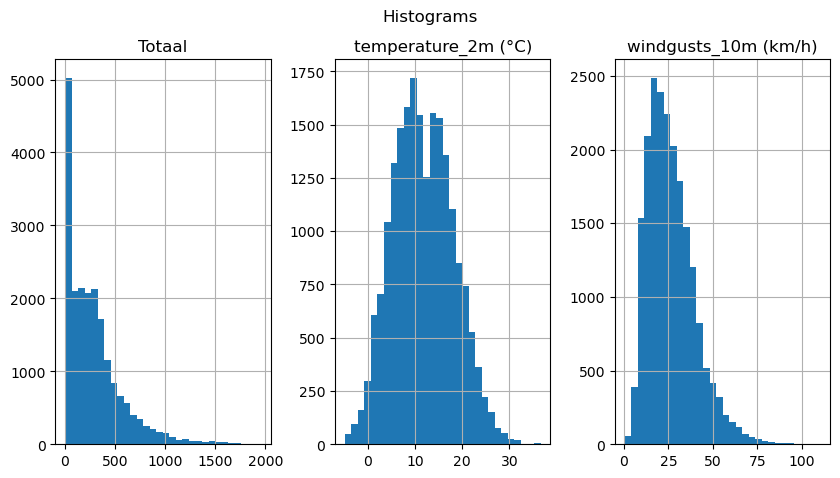

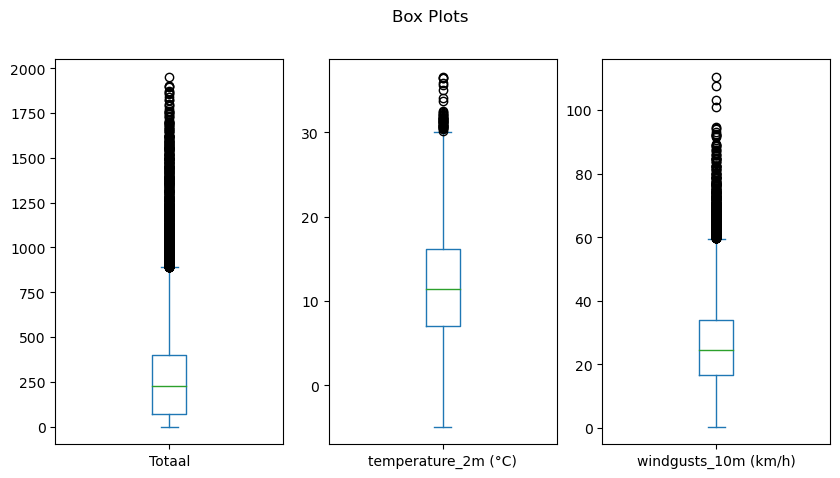

In [10]:
features = train_data.select_dtypes(include='number')

# Histograms
features.hist(figsize=(10, 5),bins=30,layout=(1,3))
plt.suptitle("Histograms")
plt.show()

# Boxplots
features.plot(kind='box', subplots=True, figsize=(10, 5),layout=(1,3))
plt.suptitle("Box Plots")
plt.show()

### 3.4 Linearity analysis

/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

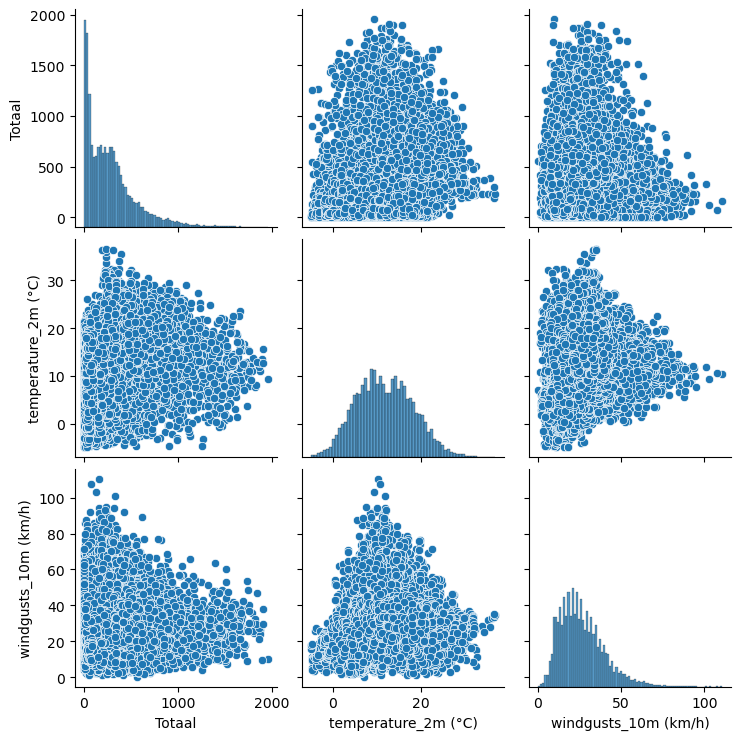

In [11]:
sns.pairplot(train_data)

A relationship with intuitive explanation can be observed between the features and number cyclists. Large windgusts and extreme temperatures on both tails prompt less cyclists.

Despite this relationship, linearity cannot be positively confirmed. A linear regression model most likely won't be able to capture the variability.

### 3.5 Time Series Analysis

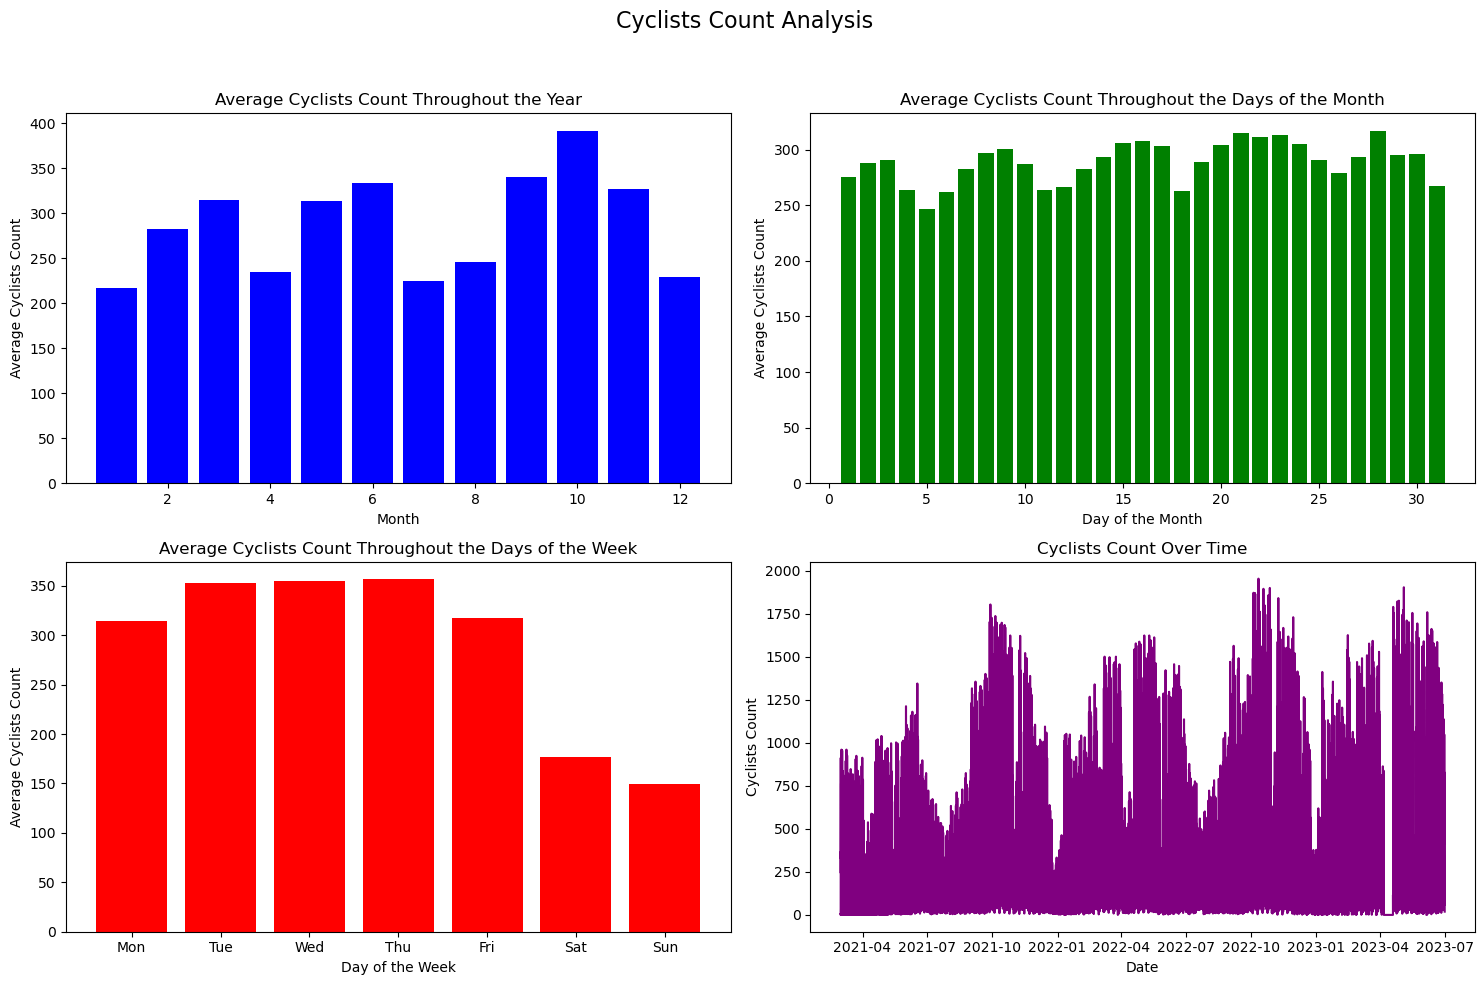

In [14]:
# Set datetime as index
train_data.set_index('datetime', inplace=True)


# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cyclists Count Analysis', fontsize=16)

# Plot 1: Average Cyclists Count Throughout the Month
monthly_avg = train_data['Totaal'].groupby(train_data.index.month).mean()
axes[0, 0].bar(monthly_avg.index, monthly_avg, color='blue')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Cyclists Count')
axes[0, 0].set_title('Average Cyclists Count Throughout the Year')

# Plot 2: Average Cyclists Count Throughout the Days of the Month
daily_avg = train_data['Totaal'].groupby(train_data.index.day).mean()
axes[0, 1].bar(daily_avg.index, daily_avg, color='green')
axes[0, 1].set_xlabel('Day of the Month')
axes[0, 1].set_ylabel('Average Cyclists Count')
axes[0, 1].set_title('Average Cyclists Count Throughout the Days of the Month')

# Plot 3: Average Cyclists Count Throughout the Days of the Week
days_avg = train_data['Totaal'].groupby(train_data.index.dayofweek).mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(days, days_avg, color='red')
axes[1, 0].set_xlabel('Day of the Week')
axes[1, 0].set_ylabel('Average Cyclists Count')
axes[1, 0].set_title('Average Cyclists Count Throughout the Days of the Week')

# Plot 4: Original Time Series Plot
axes[1, 1].plot(train_data.index, train_data['Totaal'], color='purple')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Cyclists Count')
axes[1, 1].set_title('Cyclists Count Over Time')

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# reset index
train_data = train_data.reset_index()

## 4. Feature engineering

In [ ]:
# gentse feesten 2022
gentse_feesten_start_2022 = pd.to_datetime('2022-07-15')
gentse_feesten_end_2022 = pd.to_datetime('2022-07-24')

train_data['is_gentse_feesten_active'] = (
    (train_data['datetime'] >= gentse_feesten_start_2022) &
    (train_data['datetime'] <= gentse_feesten_end_2022)
).astype(int)


# Gentse feesten 2023
gentse_feesten_start_2023 = pd.to_datetime('2023-07-14')
gentse_feesten_end_2023 = pd.to_datetime('2023-07-23')

test_data['is_gentse_feesten_active'] = (
    (test_data['datetime'] >= gentse_feesten_start_2023) &
    (test_data['datetime'] <= gentse_feesten_end_2023)
).astype(int)

In [ ]:
## 1. train_data

# Hour of the day
train_data['hour'] = train_data['datetime'].dt.hour
train_data = pd.get_dummies(train_data, columns=['hour'], prefix='hour', prefix_sep='_')

# Day of the week
days_dummies = pd.get_dummies(train_data['datetime'].dt.dayofweek, prefix='day', prefix_sep='_')
train_data = pd.concat([train_data, days_dummies], axis=1)

# Months - dummy variables
months_dummies = pd.get_dummies(train_data['datetime'].dt.month, prefix='month')
train_data = pd.concat([train_data, months_dummies], axis=1)


In [ ]:
## 2. test_data

# Extract hours into dummy variables
test_data['hour'] = test_data['datetime'].dt.hour
test_data = pd.get_dummies(test_data, columns=['hour'], prefix='hour', prefix_sep='_')

# Day of the week
days_dummies = pd.get_dummies(test_data['datetime'].dt.dayofweek, prefix='day', prefix_sep='_')
test_data = pd.concat([test_data, days_dummies], axis=1)

# months:
months_dummies = pd.get_dummies(test_data['datetime'].dt.month, prefix='month')
test_data = pd.concat([test_data, months_dummies], axis=1)


missing_months = [column for column in set(train_data.columns) if column.startswith("month") and column not in set(test_data.columns)]
for column in missing_months:
    test_data[column] = False

- Adding weekend and summer vacation period is redundant as the variance is already explained by the days and months. It would result multicollinearity with months 7 and 8 and days 6 and 7.
- Only adding a variable for weekday vs weekend did not generate a better performance than using dummy variables for all days.
- Attempted capturing cyclic behavior of the hour of the day and day of the week by encoding as sin/cos values. This did not improve the model's performance.
- Added interaction terms to the model, this did not improve the model's performance either.

In [ ]:
# drop datetime columns
train_data = train_data.drop('datetime', axis=1)
test_data = test_data.drop('datetime', axis=1)

## 5. Correlation analysis - revisited

In [ ]:
correlation = train_data.corr()['Totaal']
print(correlation.abs().sort_values(ascending=False))

These new time-related variables show decent correlation with the number of cyclists and will be retained in the model.

## 6. Model

In [ ]:
# Put data in numpy arrays
y = train_data.Totaal.values
X = train_data.drop('Totaal', axis=1).values

In [ ]:
# to test on own data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7) # Use 70% of data for training

### 6.1 Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression


LinReg = LinearRegression() # call an instance of the class LinearRegression

LinReg.fit(X_train, y_train) # fit the model on the training data
y_hat_train = LinReg.predict(X_train) # predict training data
MSE_train = mean_squared_error(y_train, y_hat_train) # Compute training set MSE

y_hat_test = LinReg.predict(X_test) # predict test data
MSE_test = mean_squared_error(y_test, y_hat_test) # Test set MSE

R_train = LinReg.score(X_train, y_train) # Training set R²
R_test = LinReg.score(X_test, y_test) # Test set R²

print('Training set MSE: {}'.format(MSE_train))
print('Test set MSE: {}'.format(MSE_test))
print('Train set R²: {}'.format(R_train))
print('Test set R²: {}'.format(R_test))

### 6.2 Random Forest Regression

In [ ]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
print(f"R-squared: {r2}")

### 6.3 XGboost

#### 6.3.1 Hyperparameter tuning

In [ ]:
## own data

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10],
    'gamma': [0, 0.1, 0.2]
}

model = XGBRegressor(
    objective='reg:squarederror'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Choose an appropriate scoring metric
    cv=5,  # Number of cross-validation folds
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Model - Mean Squared Error: {mse}")
print(f"Best Model - R-squared: {r2}")

I have chosen to focus on the 4 most important hyperparameters for tuning the algorithm. Others like 'min_child_weight', 'subsample' and 'gamma' can also improve the model, but only marginally when compared to the first 3.

- **n_estimators**: The number of trees, this will increase complexity.
- **learning_rate**: Determines how fast/slow the algorithm moves towards the optimal weights. If this is large, the model learns faster but could skip the optimal solution. If it's rather small, it may take significantly longer to train as it will need too many iterations to converge to the best values.
- **max_depth**: Controls how deep the tree goes. Increasing this parameter increases the number of splits, capturing more information at the risk of overfitting.

**Cross validation folds** are set to 5 due to the size of the dataset. A higher number of folds yield more statistically significant results but require more computational resources.

#### 6.3.2 Model implementation

In [ ]:
## tijdelijk

model = XGBRegressor(
    objective='reg:squarederror'
)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

In [ ]:
y_pred = best_model.predict(X_test)

#### 6.3.3 Evaluation

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Model - Mean Squared Error: {mse}")
print(f"Best Model - R-squared: {r2}")

In [ ]:
# Create subplots with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Scatterplot of Actual vs. Predicted Values
axes[0, 0].scatter(y_test, y_pred)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title('Actual vs. Predicted Values')

# 2. Residual Plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# 3. Distribution of Residuals
sns.histplot(residuals, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

# 4. Time Series Plot
axes[1, 1].plot(y_test, label='Actual', color='blue')
axes[1, 1].plot(y_pred, label='Predicted', color='red')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Cyclists Count')
axes[1, 1].set_title('Actual vs. Predicted Cyclists Count Over Time')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## 7. Kaggle

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

model = XGBRegressor(
    objective='reg:squarederror'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error'
    cv=5,
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X)

## y_pred[y_pred < 0] = 0

# format predictions with Ids into dataframe and save to csv.
submission_file = pd.DataFrame([test_data["Id"], y_pred]).T
submission_file.columns = ["Id", "Predicted"]

submission_file.to_csv("submission.csv", index = False)

Attempts:
- linear regression
- polynomial terms
- random forest regression

## 8. Conclusion